In [1]:
library(ggplot2)
library(data.table)
library(viridis)
library(scales)
library(UpSetR)
library(RColorBrewer)

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [2]:
# Import scanpy differential expression analysis for cNMF+/- stratified by fibroblast cell type
d = fread("data/ATACseq_cNMF1_diff_peak.csv")

In [3]:
table(d$annot1)


   MF1     PC     S1     S2     S3    S3x     S5 
 28457  40370 135327  76999  68253  70500 223334 

In [4]:
# Parse genomic coordinates
d$peak_annot = sapply(strsplit(d$names, ","), function(x) x[3])
d$gene = sapply(strsplit(d$names, ","), function(x) x[2])
                


In [51]:
d$label = paste0(d$gene, " (", d$peak_annot, ")")
d$label = factor(d$label)  # to maintain order

In [52]:
table(d$peak_annot)


  Distal   Exonic Intronic Promoter 
  222010    42601   332626    46003 

In [53]:
head(d)

names,scores,logfoldchanges,pvals,pvals_adj,annot1,peak_annot,gene,label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>
"chr4:165524624-165525124,MIR578,Distal",27.97085,3.249020,3.163872e-162,3.222269e-157,S1,Distal,MIR578,MIR578 (Distal)
"chr3:60935659-60936159,FHIT,Intronic",25.66516,2.902387,2.453428e-138,6.246780e-134,S1,Intronic,FHIT,FHIT (Intronic)
"chr1:209607303-209607803,MIR4260,Intronic",25.48550,3.101262,1.998190e-136,4.522381e-132,S1,Intronic,MIR4260,MIR4260 (Intronic)
"chr15:75579115-75579615,PTPN9,Promoter",25.40764,2.496163,6.037707e-136,1.229830e-131,S1,Promoter,PTPN9,PTPN9 (Promoter)
"chr14:102516739-102517239,ANKRD9,Distal",24.98237,2.938395,1.879851e-131,3.329649e-127,S1,Distal,ANKRD9,ANKRD9 (Distal)
"chr2:177553393-177553893,TTC30B,Promoter",24.78773,2.396939,6.502225e-130,1.103707e-125,S1,Promoter,TTC30B,TTC30B (Promoter)


# Comparative analysis of signifcant scATAC-seq peaks

In [54]:
# Define significant ATAC-seq peaks from cNMF+/- comparison per cell type (scanpy analysis)
d_sig = d[d$pvals_adj < 0.05 & d$logfoldchanges > 2]

d_sig = d_sig[d_sig$annot1 != 'S5']  # exclude S5 comparison, too few cNMF- cells to make sense


In [38]:
# Counts of significant cell types and peak annotation types
counts = aggregate(names~., data=d_sig[, c('names', 'peak_annot', 'annot1')], FUN=length)
counts

peak_annot,annot1,names
<chr>,<chr>,<int>
Distal,MF1,907
Exonic,MF1,174
Intronic,MF1,1385
Promoter,MF1,157
Distal,PC,3361
Exonic,PC,625
Intronic,PC,4990
Promoter,PC,640
Distal,S1,3442


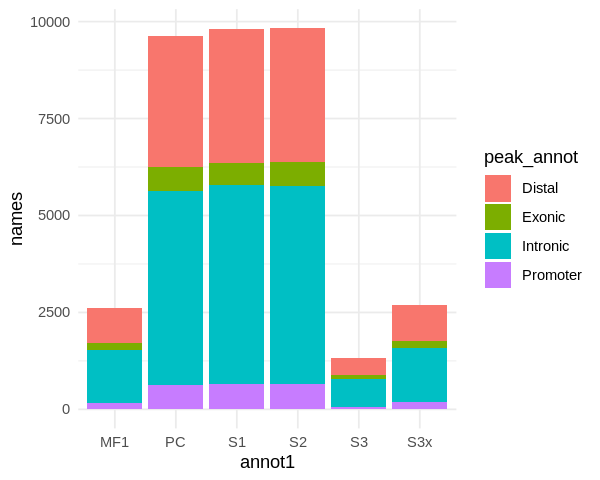

In [39]:
# Normalized barplot of peak annotation per cell type
width = 5
height = 4
options(repr.plot.width=width, repr.plot.height=height)

ggplot(counts, aes(x=annot1, y=names, fill=peak_annot)) +
    #geom_bar(position="fill", stat="identity") +
    geom_bar(stat="identity") +
    theme_minimal()

In [10]:
sig_peaks_by_cell = lapply(split(d_sig, d_sig$annot1), function(x) x$names)

cairo_pdf 
        3

png 
  2

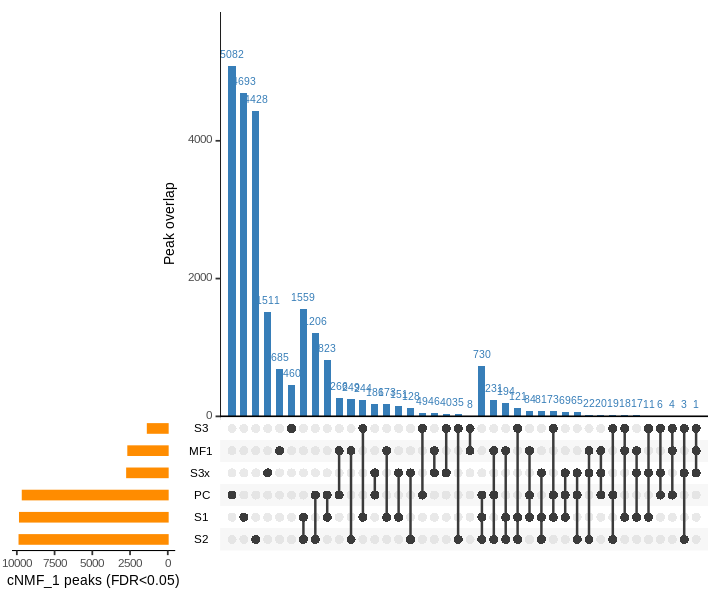

In [11]:
# Compare overlap of significant peaks by cell type
width = 6
height = 5
options(repr.plot.width=width, repr.plot.height=height)

UpSetR::upset(
    fromList(sig_peaks_by_cell),
    nsets=length(sig_peaks_by_cell),
    #group.by="sets",
    #cutoff=10,
    #queries=sig_peaks_by_cell,
    main.bar.color=brewer.pal(9, "Set1")[2],
    sets.bar.color="darkorange",
    show.numbers="yes",
    mainbar.y.label="Peak overlap",
    sets.x.label="cNMF_1 peaks (FDR<0.05)",
    cutoff=10
)

dev.copy(grDevices::cairo_pdf, "figures/cNMF1_scATAC_peaks_upset.pdf", width=width, height=height)
dev.off()

## Number of cell types

In [12]:
# count number of cell types each peak is found in.
# Assumes that each peak only occurs once per cell type in table

counts = data.frame(table(d_sig$names))
colnames(counts)[1] = "names"
counts$names = as.character(counts$names)

# peak annotation from names
counts$peak_annot = sapply(strsplit(counts$names, ","), function(x) x[3])
counts$peak_annot = factor(counts$peak_annot)                         
head(counts)

,names,Freq,peak_annot
,<chr>,<int>,<fct>
1,"chr1:100452564-100453064,GPR88,Intronic",1,Intronic
2,"chr1:10055686-10056186,UBE4B,Intronic",1,Intronic
3,"chr1:10057258-10057758,UBE4B,Intronic",2,Intronic
4,"chr1:100597286-100597786,LINC01349,Distal",1,Distal
5,"chr1:100621913-100622413,LINC01349,Distal",1,Distal
6,"chr1:100627235-100627735,LINC01349,Intronic",2,Intronic


In [13]:
# Stratify by significance
counts_by_freq = split(counts, counts$Freq)

In [14]:
head(counts_by_freq[[1]])

,names,Freq,peak_annot
,<chr>,<int>,<fct>
1,"chr1:100452564-100453064,GPR88,Intronic",1,Intronic
2,"chr1:10055686-10056186,UBE4B,Intronic",1,Intronic
4,"chr1:100597286-100597786,LINC01349,Distal",1,Distal
5,"chr1:100621913-100622413,LINC01349,Distal",1,Distal
7,"chr1:100721474-100721974,VCAM1,Intronic",1,Intronic
9,"chr1:100836118-100836618,EXTL2,Distal",1,Distal


In [15]:
count_mat = sapply(counts_by_freq, function(x) table(x$peak_annot))
count_mat_norm = scale(count_mat, center=FALSE, scale=colSums(count_mat))
count_mat

,1,2,3,4,5,6
Distal,5886,1787,644,211,60,6
Exonic,1078,310,118,35,10,0
Intronic,8787,2704,899,333,91,10
Promoter,1108,362,109,30,11,2


cairo_pdf 
        3

png 
  2

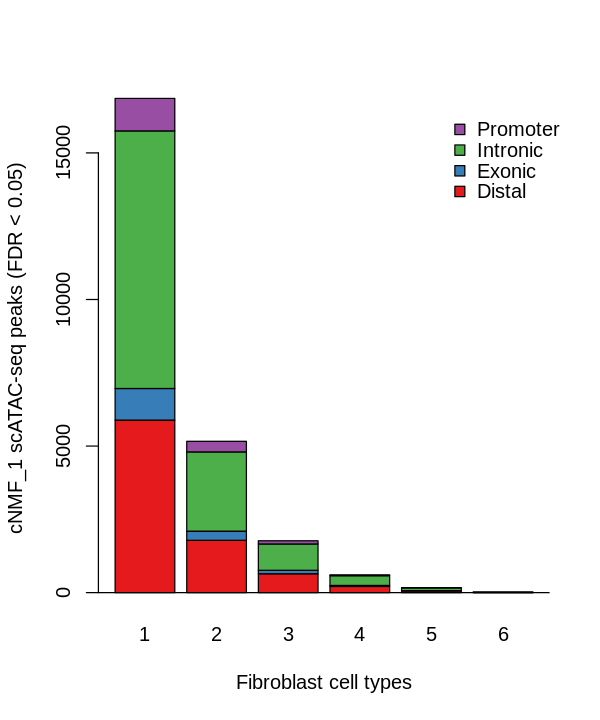

In [16]:
# Barplot
width = 5
height = 6
options(repr.plot.width=width, repr.plot.height=height)

barplot(count_mat, col=brewer.pal(9, "Set1"), ylab="cNMF_1 scATAC-seq peaks (FDR < 0.05)", xlab="Fibroblast cell types", legend=rownames(count_mat), args.legend=list(bty="n"))
abline(h=0)

dev.copy(grDevices::cairo_pdf, "figures/cNMF1_scATAC_peaks_by_cell_type.pdf", width=width, height=height)
dev.off()

## Top ATAC peaks per cell type

In [55]:
sum(table(d_sig$names) == 1)

[1] 16859

In [56]:
# Define peaks called for only one cell type as cell-type specific
cell_specific_peaks = names(which(table(d_sig$names) == 1))
cell_specific_peaks[1:10]

[1] "chr1:100452564-100453064,GPR88,Intronic"       
 [2] "chr1:10055686-10056186,UBE4B,Intronic"         
 [3] "chr1:100597286-100597786,LINC01349,Distal"     
 [4] "chr1:100621913-100622413,LINC01349,Distal"     
 [5] "chr1:100721474-100721974,VCAM1,Intronic"       
 [6] "chr1:100836118-100836618,EXTL2,Distal"         
 [7] "chr1:100866349-100866849,EXTL2,Distal"         
 [8] "chr1:100955277-100955777,SLC30A7,Intronic"     
 [9] "chr1:101004612-101005112,LOC102606465,Intronic"
[10] "chr1:10108305-10108805,UBE4B,Intronic"

In [57]:
core_peaks = names(which(table(d_sig$names) >= 6))

In [58]:
length(core_peaks)

[1] 18

In [59]:
# Stratify peak table into core and cell-type specific peaks
d_sig_cell = d_sig[d_sig$names %in% cell_specific_peaks]
dim(d_sig_cell)

# Core peak
d_sig_core = d_sig[d_sig$names %in% core_peaks]
dim(d_sig_core)

# Not cell-type specific or core peak
d_sig_mix = d_sig[(!d_sig$names %in% cell_specific_peaks) & (!d_sig$names %in% core_peaks)]
dim(d_sig_mix)


[1] 16859     9

[1] 108   9

[1] 18932     9

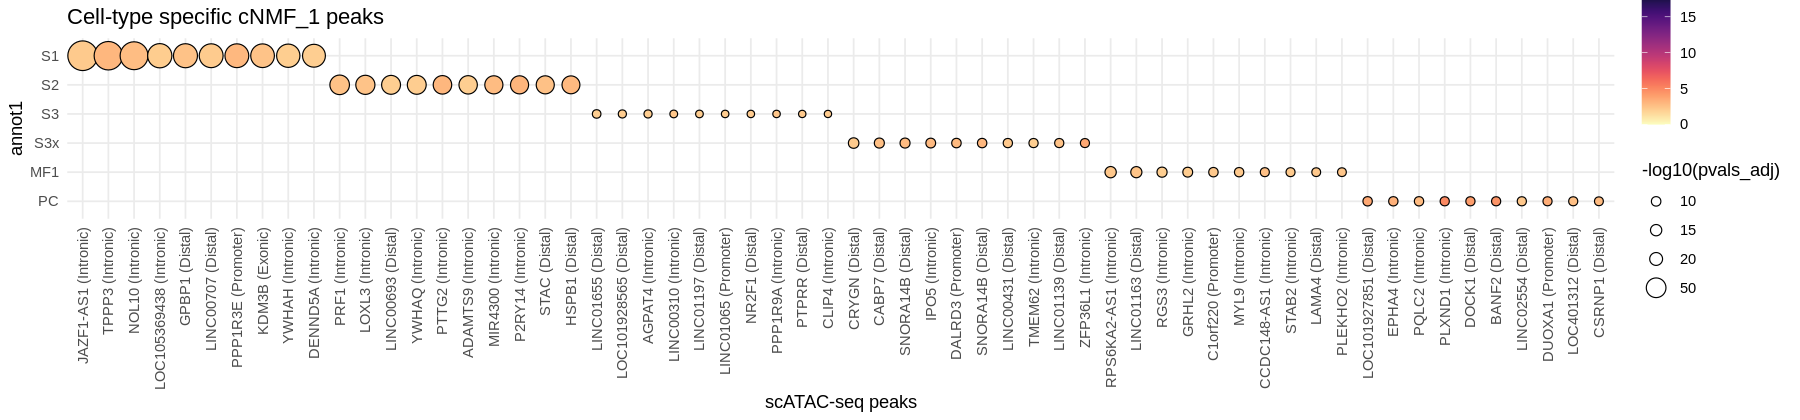

In [82]:
width = 15
height = 3.5
options(repr.plot.width=width, repr.plot.height=height)

# Define top candidate peaks
top_peaks = lapply(unique(d$annot1), function(annot) {
    d_sig_cell[d_sig_cell$annot1 == annot]$names[1:10]
})
top_peaks = unique(unlist(top_peaks))

d_sub = d_sig_cell[d_sig_cell$names %in% top_peaks]
d_sub$names = factor(d_sub$names, levels=top_peaks)  # maintain plotting order
d_sub$annot1 = factor(d_sub$annot1, levels=rev(unique(d_sub$annot1)))

ggplot(d_sub, aes(x=names, y=annot1, fill=logfoldchanges, size=-log10(pvals_adj))) +
    geom_point(pch=21) +

    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 20), oob=squish) +

    scale_size_area(max_size=8, breaks=c(2, 5, 10, 15, 20, 50)) +

    # Rename x labels including ongly gene and annotation type
    scale_x_discrete(label=function(labels) {                      
        genes = sapply(strsplit(labels, ","), function(x) x[2])
        peak_annot = sapply(strsplit(labels, ","), function(x) x[3])
        return(paste0(genes, " (", peak_annot, ")"))
    }) +
                     
    ggtitle("Cell-type specific cNMF_1 peaks") +
    xlab("scATAC-seq peaks") +

    theme_minimal() +
    theme(
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
    )

ggsave("figures/cNMF1_peaks_cell_type_specific.pdf", width=width, height=height)

In [50]:
head(d_sub)

names,scores,logfoldchanges,pvals,pvals_adj,annot1,peak_annot,gene,label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
"chr7:28099907-28100407,JAZF1-AS1,Intronic",24.06051,2.197211,7.180185e-123,6.647921e-119,S1,Intronic,JAZF1-AS1,JAZF1-AS1 (Intronic)
"chr16:67392671-67393171,TPPP3,Intronic",23.08906,3.006962,2.972555e-113,1.807415e-109,S1,Intronic,TPPP3,TPPP3 (Intronic)
"chr2:10585270-10585770,NOL10,Intronic",22.57206,2.755203,1.356286e-108,6.350895e-105,S1,Intronic,NOL10,NOL10 (Intronic)
"chr11:94734584-94735084,LOC105369438,Intronic",19.38124,2.082398,1.492158e-81,1.927426e-78,S1,Intronic,LOC105369438,LOC105369438 (Intronic)
"chr5:57298155-57298655,GPBP1,Distal",19.21387,2.539259,4.671613e-80,5.581043e-77,S1,Distal,GPBP1,GPBP1 (Distal)
"chr10:7090435-7090935,LINC00707,Distal",19.05056,2.137981,6.799287e-79,7.737189e-76,S1,Distal,LINC00707,LINC00707 (Distal)


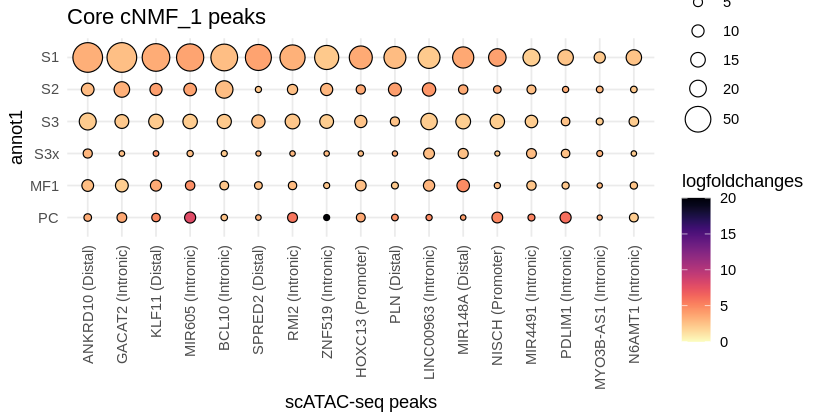

In [83]:
width = 7
height = 3.5
options(repr.plot.width=width, repr.plot.height=height)

# Define top candidate peaks
top_peaks = lapply(unique(d$annot1), function(annot) {
    d_sig_core[d_sig_core$annot1 == annot]$names[1:10]
})
top_peaks = unique(unlist(top_peaks))

d_sub = d_sig_core[d_sig_core$names %in% top_peaks]
d_sub$names = factor(d_sub$names, levels=top_peaks)  # maintain plotting order
d_sub$annot1 = factor(d_sub$annot1, levels=rev(unique(d_sub$annot1)))

ggplot(d_sub, aes(x=names, y=annot1, fill=logfoldchanges, size=-log10(pvals_adj))) +
    geom_point(pch=21) +

    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 20), oob=squish) +

    scale_size_area(max_size=8, breaks=c(2, 5, 10, 15, 20, 50)) +
    
    # Rename x labels including ongly gene and annotation type
    scale_x_discrete(label=function(labels) {                      
        genes = sapply(strsplit(labels, ","), function(x) x[2])
        peak_annot = sapply(strsplit(labels, ","), function(x) x[3])
        return(paste0(genes, " (", peak_annot, ")"))
    }) +
           

    ggtitle("Core cNMF_1 peaks") +
    xlab("scATAC-seq peaks") +

    theme_minimal() +
    theme(
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
    )
                       
ggsave("figures/cNMF1_peaks_core.pdf", width=width, height=height)

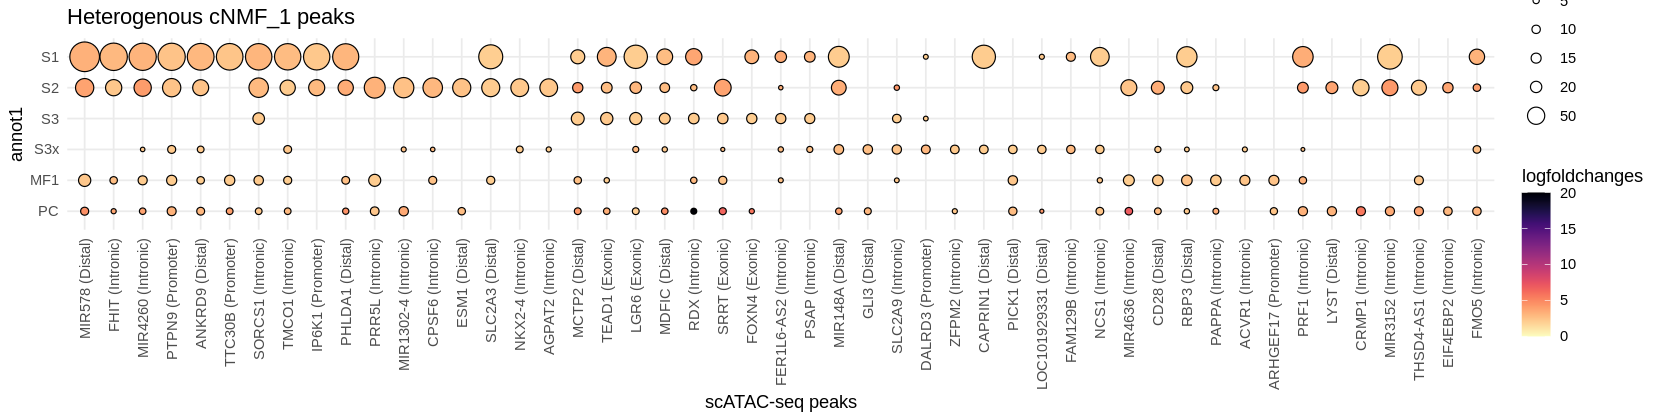

In [84]:
width = 14
height = 3.5
options(repr.plot.width=width, repr.plot.height=height)

# Define top candidate peaks
top_peaks = lapply(unique(d$annot1), function(annot) {
    d_sig_mix[d_sig_mix$annot1 == annot]$names[1:10]
})
top_peaks = unique(unlist(top_peaks))

d_sub = d_sig_mix[d_sig_mix$names %in% top_peaks]
d_sub$names = factor(d_sub$names, levels=top_peaks)  # maintain plotting order
d_sub$annot1 = factor(d_sub$annot1, levels=rev(unique(d_sub$annot1)))

ggplot(d_sub, aes(x=names, y=annot1, fill=logfoldchanges, size=-log10(pvals_adj))) +
    geom_point(pch=21) +

    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 20), oob=squish) +

    scale_size_area(max_size=8, breaks=c(2, 5, 10, 15, 20, 50)) +

    # Rename x labels including ongly gene and annotation type
    scale_x_discrete(label=function(labels) {                      
        genes = sapply(strsplit(labels, ","), function(x) x[2])
        peak_annot = sapply(strsplit(labels, ","), function(x) x[3])
        return(paste0(genes, " (", peak_annot, ")"))
    }) +
           
    ggtitle("Heterogenous cNMF_1 peaks") +
    xlab("scATAC-seq peaks") +

    theme_minimal() +
    theme(
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
    )
                       
ggsave("figures/cNMF1_peaks_hetero.pdf", width=width, height=height)

In [25]:
#options(repr.matrix.max.rows=1000)
#data.frame(d_sub)

In [26]:
#head(d_sig)

In [27]:
# # Define top candidate peaks
# top_peaks = lapply(unique(d$annot1), function(annot) {
#     d_sub = d[d$annot1 == annot & d$pvals_adj < 0.05 & d$logfoldchanges > 2]
#     d_sub$names[1:20]
# })

# top_peaks = unique(unlist(top_peaks))
# #top_peaks